In [1]:
"""
Notebook for visualizing generative model output from VAE-SSL approach to
source localization in reverberant environments

The method implemented here is described in:
1. M.J. Bianco, S. Gannot, E. Fernandez-Grande, P. Gerstoft, "Semi-supervised
source localization in reverberant environments," IEEE Access, Vol. 9, 2021.
DOI: 10.1109/ACCESS.2021.3087697

The code is based on the Pyro probabilistic programming library and Pytorch.
2. E. Bingham et al., "Pyro: Deep Universal Probabilistic Programming,"
Journal of Machine Learning Research, 2018.
3. A. Paszke et al., "Pytorch: An imperative style, high-performance deep
learning library," Proc. Adv. Neural Inf. Process. Syst., 2019, pp. 8024–8035.

If you find this code usefult for your research, please cite (1)--(3).
Michael J. Bianco, July 2021
mbianco@ucsd.edu
"""

import torch
import numpy as np
from vaessl_core import SSVAE
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18}) 
plt.rcParams['figure.figsize'] = [15,5]


# Loading saved model parameters

In [2]:
model_file = 'save_models/vaessl_model_5e-05-1000-256_J1000_Mon_Jul_12_080017_2021.cpkt'
model_dict = torch.load(model_file)
model_dict.keys()

dict_keys(['cuda_id', 'num_epochs', 'aux_loss', 'aux_loss_multiplier', 'enum_discrete', 'sup_num', 'z_dim', 'learning_rate', 'beta_1', 'batch_size', 'seed', 'output_size', 'num_bins', 'n_seq_frames', 'train_data', 'valid_data', 'path_save', 'temp_name', 'label set', 'model_state_dict', 'train acc epoch', 'valid acc epoch'])

# Instantiating data loaders

In [3]:
import utils.data_cls as data_cls

path='/home/mbianco/__gen_doa/__pyro_vae2/DTU_RIR_06-Sep-2020_speech_big1.mat'
cuda_id = 1 # set to None to run on cpu
nLabels = 1000
BATCH_SIZE = 256

data_obj = data_cls.DataClass(path=path,addNoise=True,cuda_id=1,loader_shuffle = False) 
loader_obj = data_obj.get_vaessl_data(nLabels=model_dict['sup_num'],batch_size=BATCH_SIZE,nframes=model_dict['n_seq_frames'],nBins=model_dict['num_bins'])

    

noise frac: 0.1


/home/mbianco/gendoa_repo_new/utils/data_cls.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rtf_labels  = np.array(rtf_labels)


nlabels: 988
train frames shape: (988, 31, 127)
test frames shape: (98933, 31, 127)
bad frames shape: (11370, 31, 127)


# Instantiating model and loading weights

In [6]:
model = SSVAE(z_dim=model_dict['z_dim'],
               cuda_id=cuda_id,
               output_size = model_dict['output_size'],
               input_size  = (model_dict['n_seq_frames'],model_dict['num_bins']))

model.load_state_dict(model_dict['model_state_dict'])


<All keys matched successfully>

# Obtaining reconstructions

In [7]:
BATCH_SIZE = 256
label_loader= np.array(data_obj._label_set)


recon_save = []
label_save = []
z_save = []
z_loc_save = []
z_var_save = []
input_save = []

recon_mean_save  = []
recon_var_save = []

alpha_save = []

for i, data in enumerate(loader_obj['test']):  
    xs = data[0]
    ys = data[1]

    if xs.shape[0] == BATCH_SIZE:    
        output = model.reconstruct_img2(xs,ys)  
        
        recon  = output[0].reshape(BATCH_SIZE,31,127).cpu().detach().numpy()  
        z_save0 = output[1].cpu().detach().numpy().squeeze()
        
        recon_mean = output[2].reshape(BATCH_SIZE,31,127).cpu().detach().numpy()  
        recon_var  = output[3].reshape(BATCH_SIZE,31,127).cpu().detach().numpy() 
        
        labels0 = ys.argmax(axis=1).cpu().detach().numpy() 
        labels = label_loader[labels0]
        
        recon_save.extend(recon)
        label_save.extend(labels)
        z_save.extend(z_save0)
        
        input_save.extend(xs.reshape(BATCH_SIZE,31,127).cpu().numpy())
        
        recon_mean_save.extend(recon_mean)
        recon_var_save.extend(recon_var)

In [10]:
class frames:
    def __init__(self,nAllow = 10):
        self.nAllow = nAllow   # number of frames per DOA
    
    def get_frames(self,label_save,data_save):
        a=set(label_save)

        df =  {k: [] for k in a}  # frame dictionary

        for k in range(len(label_save)):
            type(k)
            df[label_save[k]].append(data_save[k])
        input_plot = []
        label_plot = []

        for k in range(self.nAllow):
            for l in a: 
                label_plot.append([l])
                input_plot.append(df[l][k]) 

        label_plot = np.array(label_plot)
        label_plot = label_plot.flatten()
        input_plot = np.array(input_plot)

        inds = label_plot.argsort()
        label_plot = label_plot[inds]
        input_plot = input_plot[inds,:,:]

        input_plot2 = []
        for k in range(input_plot.shape[0]):
            input_plot0 = input_plot[k,:,:].copy()
            input_plot2.extend(input_plot0)

        input_plot = np.array(input_plot2)

        return input_plot, label_plot
    

In [11]:
frame = frames()
input_plot,label_plot = frame.get_frames(label_save,input_save)
recon_plot,_          = frame.get_frames(label_save,recon_save)
recon_mean_plot,_       = frame.get_frames(label_save,recon_mean_save)
recon_var_plot,_        = frame.get_frames(label_save,recon_var_save)


# Plotting free space RTF-phase sequences

(5890, 127)

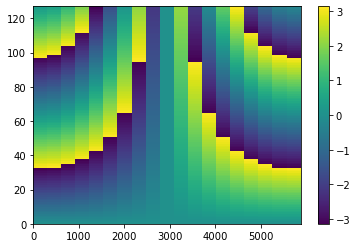

In [13]:
freqs = np.arange(0,127)*16e3/256
r = 0.085 #m
c = 343 #m/s
doas = np.linspace(-90,90,len(label_loader))
rtf_free_phase = []
nAllow = 10*31
for doa in doas:
    for k in range(nAllow):
        rtf_free = np.exp(2j*np.pi*freqs/c*r*np.sin(doa*np.pi/180))
        rtf_free_phase.append(np.angle(rtf_free))

rtf_free_phase = np.array(rtf_free_phase)
plt.pcolor(rtf_free_phase.T)
plt.colorbar()

rtf_free_phase.shape

# Plotting generated RTF-phase sequences (reconstruction). This is Figure 4 from Ref [1], Bianco et al. 2021

9.934503


[Text(1, 0, '$-\\pi$'), Text(1, 0, '0'), Text(1, 0, '$\\pi$')]

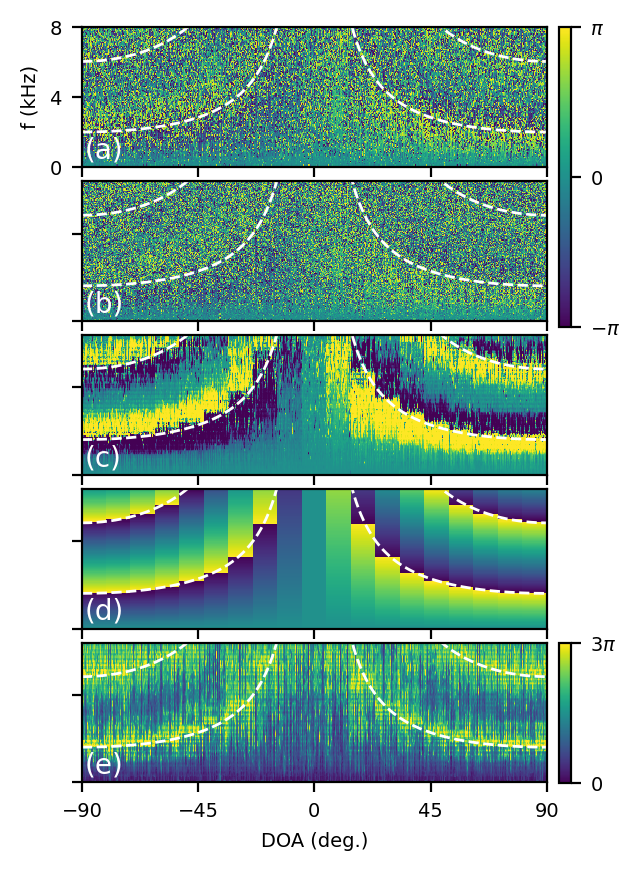

In [14]:
plt.rcParams.update({'font.size': 7}) # all fontsizes

xp = np.linspace(-90,90,recon_plot.shape[0])
xm,ym=np.meshgrid(xp,np.linspace(0,8,127))

results = [input_plot*np.pi, recon_plot*np.pi, recon_mean_plot*np.pi, rtf_free_phase, np.sqrt(recon_var_plot)*np.pi] # adding variance

f = 343/(2*.085*np.abs(np.sin(xp*np.pi/180)))/1000

fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (3,5), dpi = 200)

plot_labels =['(a)','(b)','(c)','(d)','(e)'] 

for k in range(len(results)):
    ax_plot = axes[k]
    if k ==0:       
        im = ax_plot.pcolormesh(xm,ym,results[k].T,vmin=-np.pi,vmax=np.pi)
    elif k ==4: 
        im2 = ax_plot.pcolormesh(xm,ym,results[k].T,vmin=0,vmax=3*np.pi)
    else:       
        im2 = ax_plot.pcolormesh(xm,ym,results[k].T,vmin=-np.pi,vmax=np.pi)
        
    width = 1.0

    ax_plot.plot(xp,f,'w--',linewidth = width)
    ax_plot.plot(xp,3*f,'w--',linewidth = width)
    ax_plot.set_ylim([0,8])
    ax_plot.set_xticks(np.arange(-90,135,45))
    
    ax_plot.text(-89,0.5,plot_labels[k],color='w',fontsize=10)
    
    if k == 0:
        ax_plot.set_ylabel('f (kHz)')
        ax_plot.set_yticks([0,4,8])
            
    if k == 4:
        ax_plot.set_xlabel('DOA (deg.)')
        cbar_ax = fig.add_axes([0.92, 0.124, 0.02, 0.14])
        cbar = fig.colorbar(im2,cbar_ax, ticks = [0,3*np.pi]) #ax=ax_plot)
        cbar.ax.set_yticklabels(['$0$','$3\pi$'])
        print(np.max(results[k].T))
        
    if k != 0:
        ax_plot.set_yticklabels([])
        
    if k != 4:
        ax_plot.set_xticklabels([])
        
fig.subplots_adjust(right=0.9,hspace=0.1)
cbar_ax = fig.add_axes([0.92, 0.58, 0.02, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax, ticks = [-np.pi,0,np.pi])
cbar.ax.set_yticklabels(['$-\pi$','0','$\pi$'])
        

# Generated RTF-phase sequence histogrames. This is Figure 10 (a,c) from Ref [1], Bianco et al. 2021

DOA (deg): 20.0


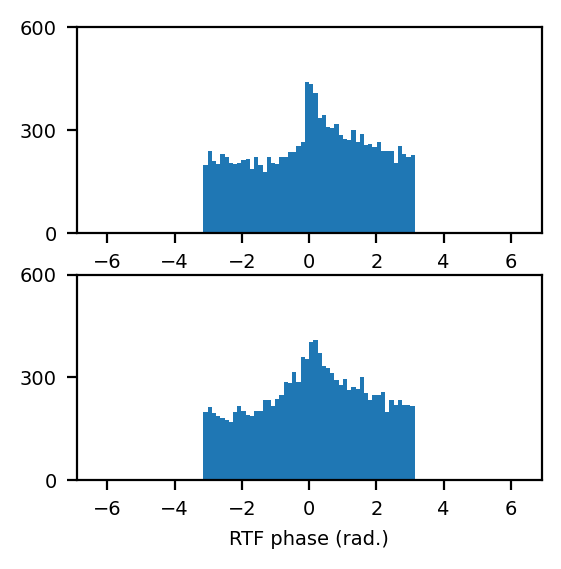

In [17]:
start_ind = 11 # choosing DOA from reconstructed RTF-phase
start = 310*start_ind 
data_hist1 = results[0] 
data_hist2 = results[1] 
pix1 = data_hist1[start:start+100,:].flatten() 
pix2 = data_hist2[start:start+100,:].flatten()

pix_l = [pix1,pix2]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (3,3), dpi = 200)
for pix,ax in zip(pix_l,axes):
    ax.hist(pix,50)
    ax.set_xlim([-2*np.pi*1.1,2*np.pi*1.1])
    ax.set_xlabel('RTF phase (rad.)')
    ax.set_ylim([0,600])
    ax.set_yticks([0,300,600])
    

doa = np.linspace(-90,90,19)[start_ind]
print("DOA (deg):",doa)


# Obtaining conditionally generated RTF-phase sequences

In [24]:
print('Choose DOA from label set:', data_obj._label_set)

Choose DOA from label set: [0.0, -30.0, -60.0, 90.0, -90.0, 70.0, 40.0, 10.0, -20.0, -50.0, -80.0, 80.0, 50.0, 20.0, -10.0, -40.0, -70.0, 60.0, 30.0]


In [39]:
doa_choice = -30.
nSamples = 100
labIndex = (np.array(data_obj._label_set)==doa_choice).argmax()
ys_sample = np.zeros((nSamples,19))
ys_sample[:,labIndex]=1
ys_sample = torch.tensor(ys_sample.astype('float32')).cuda(cuda_id)



sample_plot = []
sample_mean_plot  = []
sample_var_plot = []

output = model.cond_sample(ys_sample)  # z sampled from prior
sample = output[0].reshape(-1,31,127).cpu().detach().numpy()
sample_mean = output[2].reshape(-1,31,127).cpu().detach().numpy()
sample_var  = output[3].reshape(-1,31,127).cpu().detach().numpy()


for k in range(sample.shape[0]):
    sample_plot.extend(sample[k,:,:])
    sample_mean_plot.extend(sample_mean[k,:,:])
    sample_var_plot.extend(sample_var[k,:,:])
    
sample_plot      = np.array(sample_plot)
sample_mean_plot = np.array(sample_mean_plot)
sample_var_plot  = np.array(sample_var_plot)

doa = label_loader[labIndex]

In [40]:
# sample_mean.shape
sample_plot.shape
# sample.shape

(3100, 127)

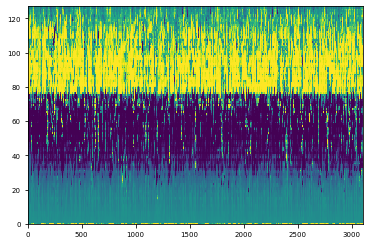

In [41]:
plt.pcolormesh(sample_mean_plot.T)

# Plotting free space RTF-phase for chosen DOA

(3100, 127)

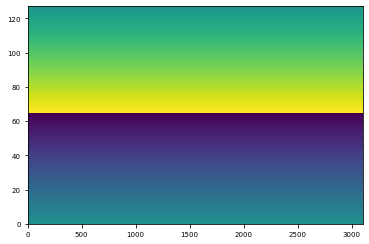

In [44]:
freqs = np.arange(0,127)*16e3/256
r = 0.085 #m
c = 343 #m/s

rtf_free_phase_single = []
nAllow = 100*31

for k in range(nAllow):
    rtf_free = np.exp(2j*np.pi*freqs/c*r*np.sin(doa*np.pi/180))
    rtf_free_phase_single.append(np.angle(rtf_free))

rtf_free_phase_single = np.array(rtf_free_phase_single)
plt.pcolor(rtf_free_phase_single.T)

rtf_free_phase_single.shape

# Conditionally RTF-phase sequence plots. This is Figure 5,6 from Ref [1], Bianco et al. 2021

DOA:  -30.0


[Text(1, 0, '$-\\pi$'), Text(1, 0, '0'), Text(1, 0, '$\\pi$')]

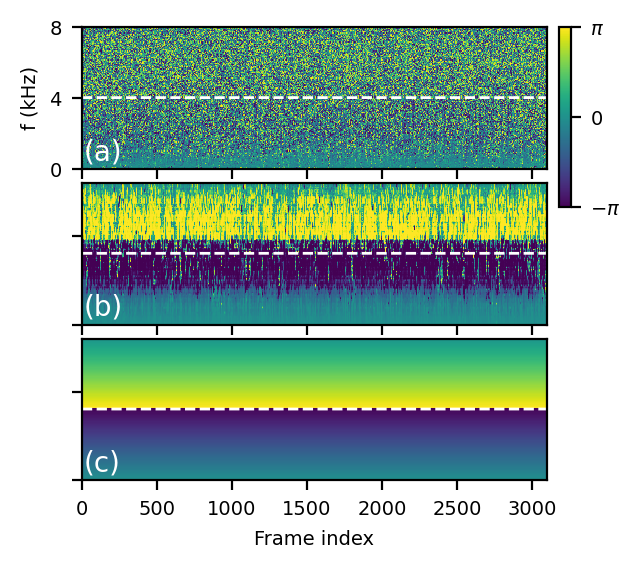

In [48]:
xp = np.arange(0,sample_plot.shape[0])
xm,ym=np.meshgrid(xp,np.linspace(0,8,127))

results2 = [sample_plot*np.pi, sample_mean_plot*np.pi, rtf_free_phase_single]


print('DOA: ',label_loader[labIndex])

f = 343/(2*r*np.abs(np.sin(np.ones(sample_plot.shape[0])*label_loader[labIndex]*np.pi/180)))/1000

fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (3,3), dpi = 200)

plot_labels =['(a)','(b)','(c)']

for k in range(len(results2)):
    ax_plot = axes[k]
    if k ==0:
        im = ax_plot.pcolormesh(xm,ym,results2[k].T,vmin=-np.pi,vmax=np.pi)
    else:
        ax_plot.pcolormesh(xm,ym,results2[k].T,vmin=-np.pi,vmax=np.pi)

    width = 1.0

    ax_plot.plot(xp,f,'w--',linewidth = width)
    ax_plot.plot(xp,3*f,'w--',linewidth = width)
    ax_plot.set_ylim([0,8])
    
    ax_plot.text(10,0.5,plot_labels[k],color='w',fontsize=10) 
       
    if k == 0:
        ax_plot.set_ylabel('f (kHz)')
        ax_plot.set_yticks([0,4,8])
            
    if k == 2:
        ax_plot.set_xlabel('Frame index')
        
    if k != 0:
        ax_plot.set_yticklabels([])
        
    if k != 2:
        ax_plot.set_xticklabels([])
        
fig.subplots_adjust(right=0.9,hspace=0.1)
cbar_ax = fig.add_axes([0.92, 0.58, 0.02, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax, ticks = [-np.pi,0,np.pi])
cbar.ax.set_yticklabels(['$-\pi$','0','$\pi$'])
        

# Function for calculating and plotting IFFT (time delay) of generated RTF

In [19]:
def ifft_plot(input_data,doa=None):
    
    NFFT = 256
    

    RTF = np.exp(1j*input_data)


    RTF_ifft = []
    for k in range(RTF.shape[0]):
        RTF_ifft.append(np.fft.ifft(RTF[k,:],n=NFFT))

    RTF_ifft = np.array(RTF_ifft)


    plt.figure(figsize = (10,6), dpi = 100)
    realz = np.real(RTF_ifft)
    realz = np.concatenate((realz[:,NFFT//2:],realz[:,0:NFFT//2]),axis=1)

    delays = -np.arange(-128,128)/16e3*1000

    count = 0
    for k in range(1,RTF_ifft.shape[0],310):
        realz_plot = realz[k,:]
        isort = abs(realz_plot).argsort()
        imax = isort[-1] #isort[-1]
        rmax = realz_plot[imax]
        tmax = delays[imax]
#         print(tmax,rmax)
        shift = 0.5*k/310
        plt.plot(delays,realz_plot*1.5+shift)
        plt.scatter(tmax,rmax*1.5+shift)

        count+=1


    plt.xlabel('Time delay (ms)')
    plt.xlim([-1,1])

    if doa: 
        angs = np.ones(count)*doa*np.pi/180 
        correctDelay =  r/c*np.sin(angs)*1000
        plt.plot(correctDelay,np.linspace(-10,100,count),'k--')
        plt.ylim([-0.3,5.3])
    else:
        angs = np.linspace(-90,90,count)*np.pi/180
        correctDelay =  r/c*np.sin(angs)*1000
        plt.plot(correctDelay,np.arange(0,count)*0.5,'k--')
        plt.ylim([-0.3,10])


    labels = np.linspace(-90,90,19)
    leg = [str(k) for k in labels]
    plt.yticks([])


# IFFT of reconstructed RTF, with correct time delay dashed black line

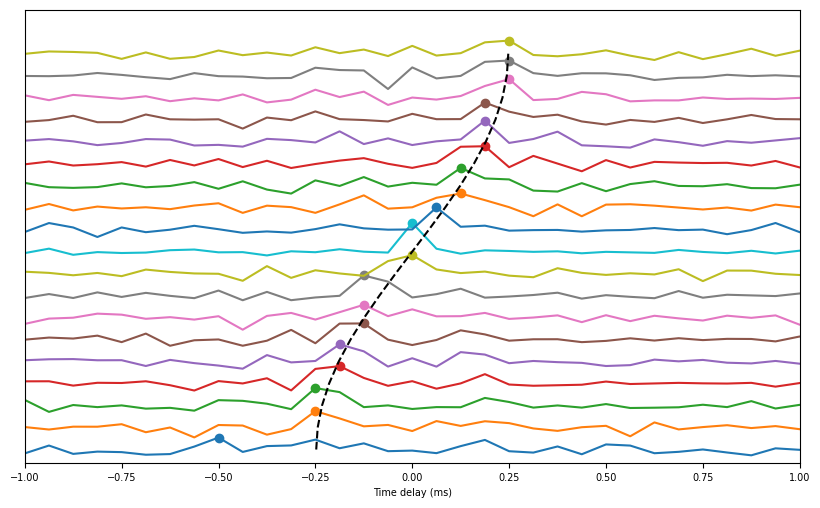

In [20]:
ifft_plot(input_data=recon_mean_plot*np.pi,doa=None)


# IFFT of conditionally generated RTF

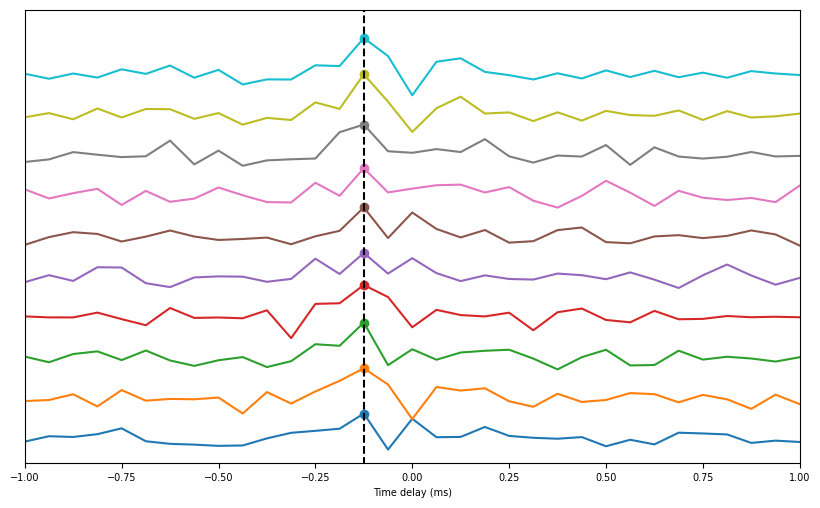

In [21]:
ifft_plot(input_data=sample_mean_plot*np.pi,doa=-30.)
